In [75]:
#Importing necessary libraries
!pip install tdqm
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
from tqdm import trange
from torch.autograd import grad


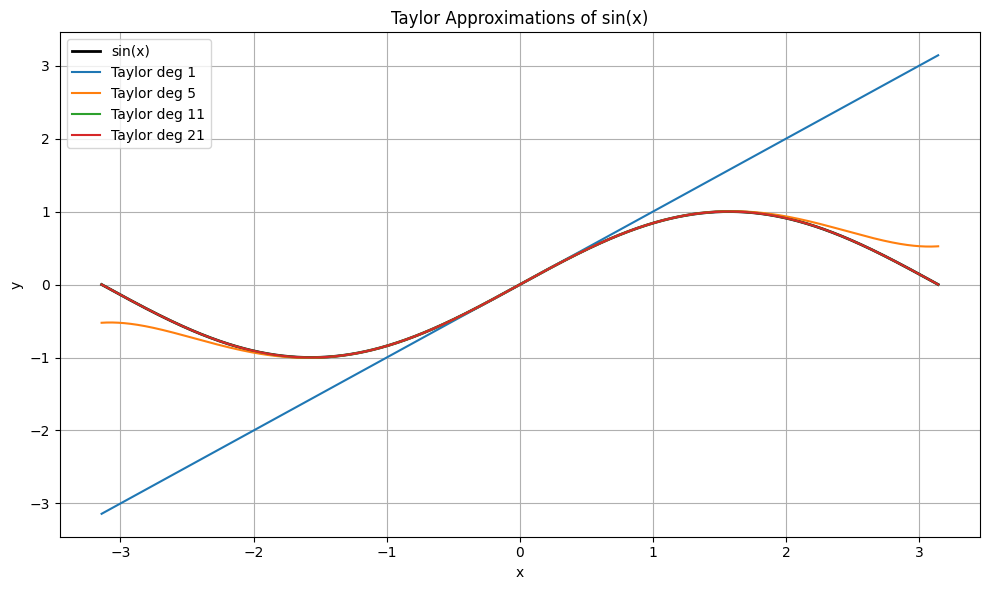

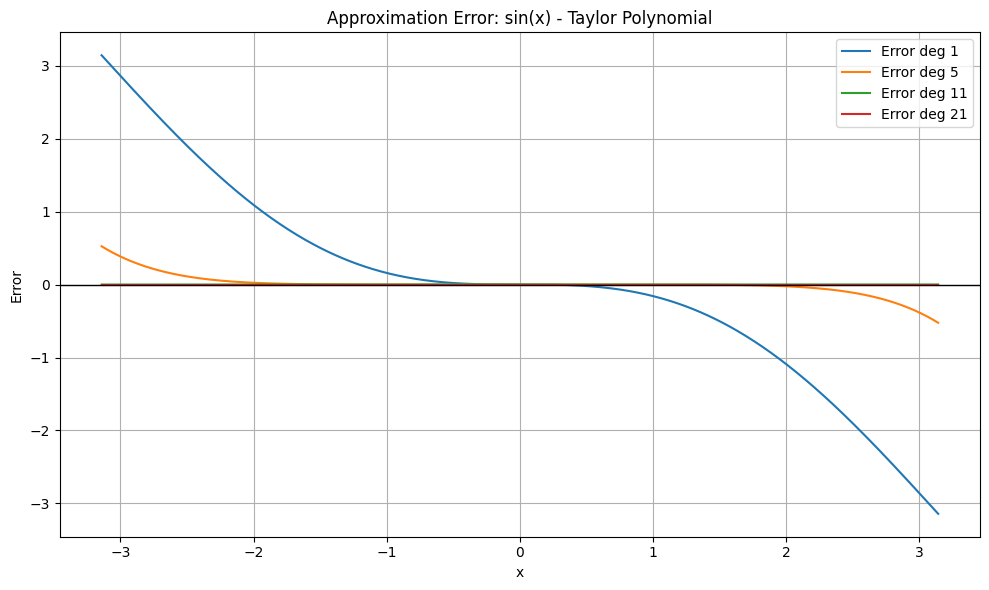

In [50]:
"""
HW4 Problem 2A part 3: Write a python code which visualizes 
how well Taylor’s polynomials of degrees 1, 5, 11, and 21 
approximates f on I = [-π, π]. 
"""

# Function to compute Taylor polynomial of sin(x)
def taylor_sin(x, degree):
    result = np.zeros_like(x, dtype=float)
    for k in range(degree // 2 + 1):
        coef = (-1)**k / factorial(2 * k + 1)
        result += coef * x**(2 * k + 1)
    return result

# Create x values on [-pi, pi]
x = np.linspace(-np.pi, np.pi, 1000)
true_sin = np.sin(x)
degrees = [1, 5, 11, 21]

# First: plot sin(x) and approximations
plt.figure(figsize=(10, 6))
plt.plot(x, true_sin, label='sin(x)', linewidth=2, color='black')

for deg in degrees:
    approx = taylor_sin(x, deg)
    plt.plot(x, approx, label=f'Taylor deg {deg}')

plt.title('Taylor Approximations of sin(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Now: plot error curves
plt.figure(figsize=(10, 6))
for deg in degrees:
    approx = taylor_sin(x, deg)
    error = true_sin - approx
    plt.plot(x, error, label=f'Error deg {deg}')

plt.title('Approximation Error: sin(x) - Taylor Polynomial')
plt.xlabel('x')
plt.ylabel('Error')
plt.axhline(0, color='black', linewidth=1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


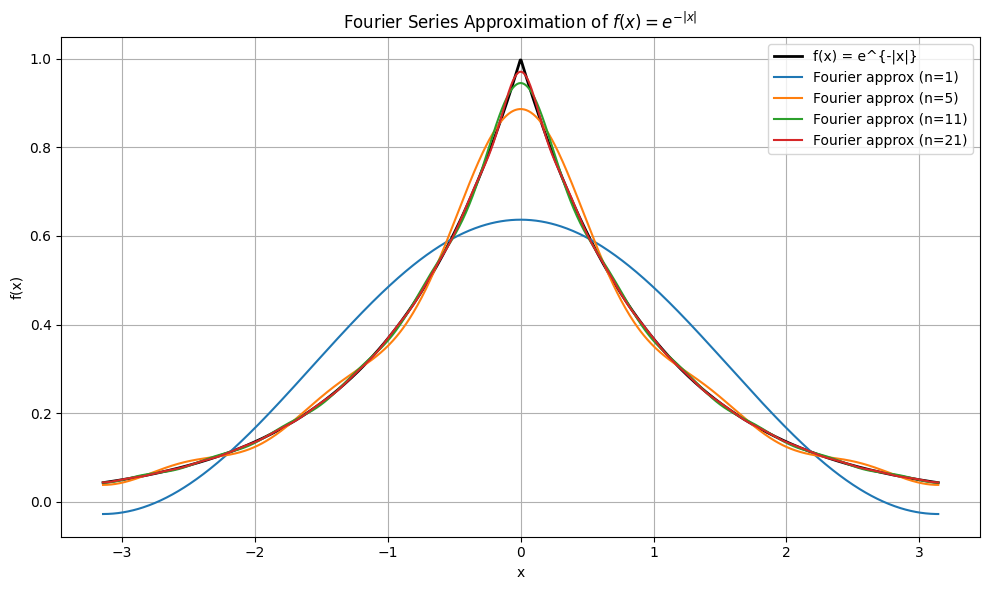

In [51]:
"""
HW4 Problem 2B part 3:  Write a python code which visualizes how the 
Fourier series with terms up to of degrees n = 1,
n = 5, n = 11, and n = 21 approximates f on (−π, π)
"""

# Define the target function f(x) = e^{-|x|}
def f(x):
    return np.exp(-np.abs(x))

# Fourier cosine coefficients for even function f(x) = e^{-|x|}
#a_0 (constant term) and a_n (cosine coefficients)
# f is even, so we only need cosine terms (no sine terms)
def a_n(n):
    if n == 0:
        return (1 - np.exp(-np.pi)) / np.pi
    else:
        return (2 / np.pi) * (1 - (-1)**n * np.exp(-np.pi)) / (1 + n**2)

# Compute the truncated Fourier series up to degree N
def fourier_series(x, N):
    series = np.full_like(x, a_n(0))  # constant term
    for n in range(1, N+1):
        series += a_n(n) * np.cos(n * x)
    return series

# Domain: (-pi, pi)
x = np.linspace(-np.pi, np.pi, 1000)
true_f = f(x)

# Degrees to test
degrees = [1, 5, 11, 21]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, true_f, label='f(x) = e^{-|x|}', color='black', linewidth=2)

for N in degrees:
    approx = fourier_series(x, N)
    plt.plot(x, approx, label=f'Fourier approx (n={N})')

plt.title('Fourier Series Approximation of $f(x) = e^{-|x|}$')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


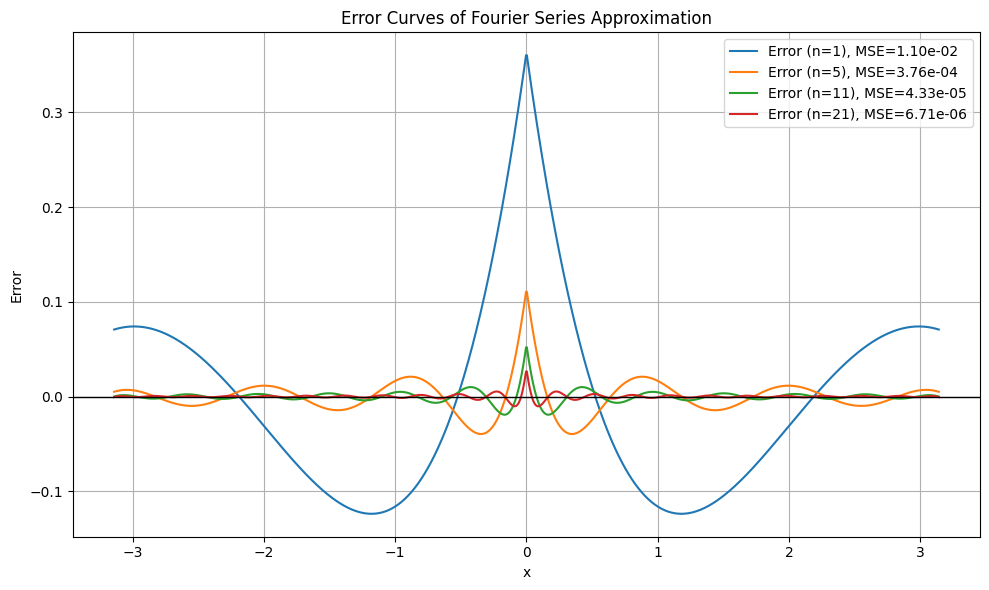

[(1, 0.010964267026722237),
 (5, 0.0003764033973914439),
 (11, 4.334710285669138e-05),
 (21, 6.7065243678717604e-06)]

In [52]:
"""
HW4 Problem 2B part 3 error curves per degree
"""
# Plot error curves and compute MSE for each degree
plt.figure(figsize=(10, 6))
mse_values = []

for N in degrees:
    approx = fourier_series(x, N)
    error = true_f - approx
    mse = mean_squared_error(true_f, approx)
    mse_values.append((N, mse))
    plt.plot(x, error, label=f'Error (n={N}), MSE={mse:.2e}')

plt.axhline(0, color='black', linewidth=1)
plt.title('Error Curves of Fourier Series Approximation')
plt.xlabel('x')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the MSE values
mse_values


-------------------------------------------------
2C: Shallow and deep neural network.
-------------------------------------------------
### C.1: Theoretical Background

The **Universal Approximation Theorem** states that a feedforward neural network with a single hidden layer and a finite number of neurons can approximate any continuous function on a compact domain, given a suitable activation function and set of weights. More precisely:

> Let $f : [a, b] \to \mathbb{R}$ be a continuous function, and let $\varepsilon > 0$. Then, there exists a neural network $f_\theta$ with one hidden layer such that:
>
> $$
> \sup_{x \in [a, b]} |f(x) - f_\theta(x)| < \varepsilon
> $$

This result holds under the condition that the activation function is **non-linear** and **non-polynomial**, such as the sigmoid, hyperbolic tangent, or ReLU. More general forms of the theorem apply to multi-dimensional input domains (i.e., $f: \mathbb{R}^d \to \mathbb{R}$) and to a broader class of activation functions.

The implications of the theorem are substantial: it guarantees that neural networks are theoretically capable of approximating any continuous function to arbitrary precision — no matter how complex — provided they have enough capacity.

However, the theorem does **not** provide:
- A bound on the number of neurons required
- Any guarantee that training algorithms (like gradient descent) will find the right parameters
- Any insight into generalization to unseen data

While shallow networks can approximate any continuous function in theory, doing so may require **a very large number of neurons**, which makes them inefficient in practice. In contrast, **deep networks** can approximate certain classes of functions more efficiently by **composing hierarchical features** across layers. This enables them to use **fewer parameters** to model complex behaviors. However, depth introduces challenges like **optimization instability**, **vanishing gradients**, and **longer training times**.

In summary, the Universal Approximation Theorem establishes that shallow networks are powerful in theory, but deep networks are often more **practical** and **efficient** in real-world scenarios — though harder to train.




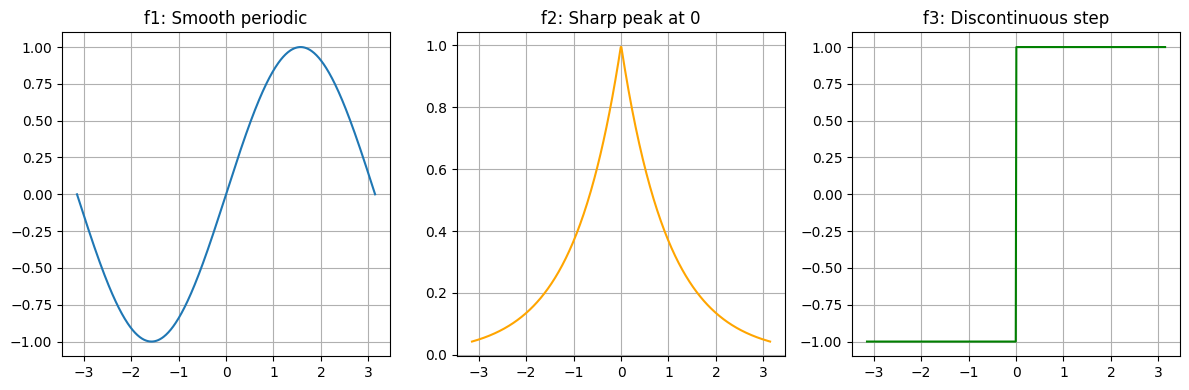

In [53]:
"""
C2: Data preparation
"""
# Define the domain: I = [-pi, pi]
N = 500
x = np.linspace(-np.pi, np.pi, N).reshape(-1, 1)  # Inputs

# Define target functions
f1 = np.sin(x)                     # f1(x) = sin(x)
f2 = np.exp(-np.abs(x))           # f2(x) = exp(-|x|)
f3 = np.where(x < 0, -1.0, 1.0)   # f3(x) = -1 for x in [-pi, 0), 1 for x in (0, pi]

# Visualize the target functions
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(x, f1, label='f1(x) = sin(x)')
plt.title("f1: Smooth periodic")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(x, f2, label='f2(x) = exp(-|x|)', color='orange')
plt.title("f2: Sharp peak at 0")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(x, f3, label='f3(x) = step function', color='green')
plt.title("f3: Discontinuous step")
plt.grid(True)

plt.tight_layout()
plt.show()

# Create training and validation splits (80% train, 20% val)
indices = np.arange(N)
np.random.seed(42)
np.random.shuffle(indices)
train_idx = indices[:int(0.8 * N)]
val_idx = indices[int(0.8 * N):]

# Split data
x_train, x_val = x[train_idx], x[val_idx]
f1_train, f1_val = f1[train_idx], f1[val_idx] #labels for f1
f2_train, f2_val = f2[train_idx], f2[val_idx] #labels for f2
f3_train, f3_val = f3[train_idx], f3[val_idx] #labels for f3

# Set device for PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32).to(device)
f1_train_tensor = torch.tensor(f1_train, dtype=torch.float32).to(device)
f1_val_tensor = torch.tensor(f1_val, dtype=torch.float32).to(device)
f2_train_tensor = torch.tensor(f2_train, dtype=torch.float32).to(device)
f2_val_tensor = torch.tensor(f2_val, dtype=torch.float32).to(device)
f3_train_tensor = torch.tensor(f3_train, dtype=torch.float32).to(device)
f3_val_tensor = torch.tensor(f3_val, dtype=torch.float32).to(device)



--- Results for f1(x) = sin(x) ---


Width  5 → Val MSE: 8.8940e-02, Time: 1.25s


Width 10 → Val MSE: 2.3221e-03, Time: 1.20s


Width 20 → Val MSE: 5.7655e-04, Time: 1.19s


Width 50 → Val MSE: 3.9439e-05, Time: 1.28s

--- Results for f2(x) = exp(-|x|) ---


Width  5 → Val MSE: 1.9880e-03, Time: 1.36s


Width 10 → Val MSE: 5.2968e-04, Time: 1.22s


Width 20 → Val MSE: 8.9877e-04, Time: 1.19s


Width 50 → Val MSE: 1.2918e-04, Time: 1.32s

--- Results for f3(x) = step(x) ---


Width  5 → Val MSE: 2.0869e-02, Time: 1.25s


Width 10 → Val MSE: 3.4086e-02, Time: 1.29s


Width 20 → Val MSE: 1.9566e-02, Time: 1.31s


Width 50 → Val MSE: 2.2407e-02, Time: 1.21s


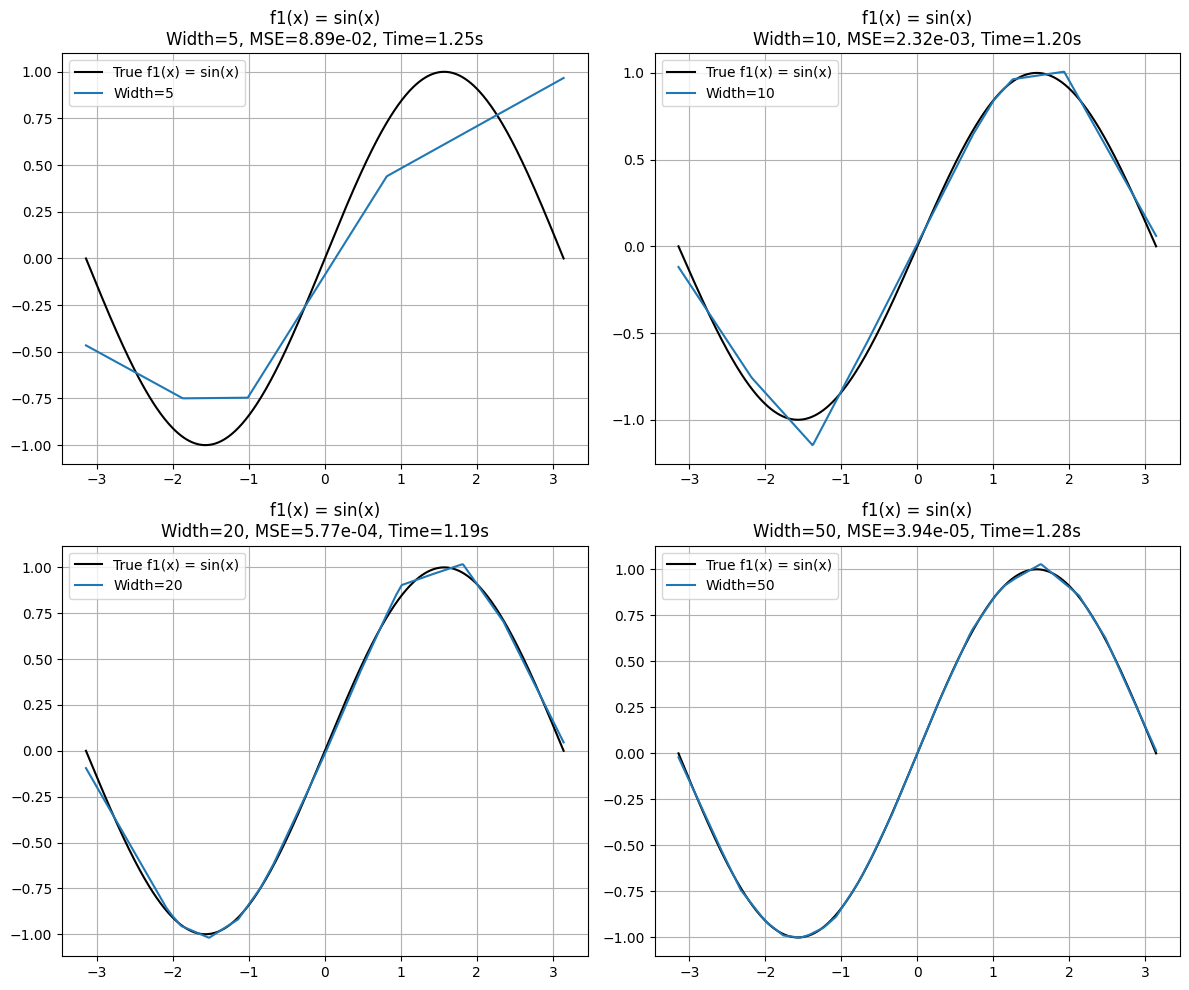

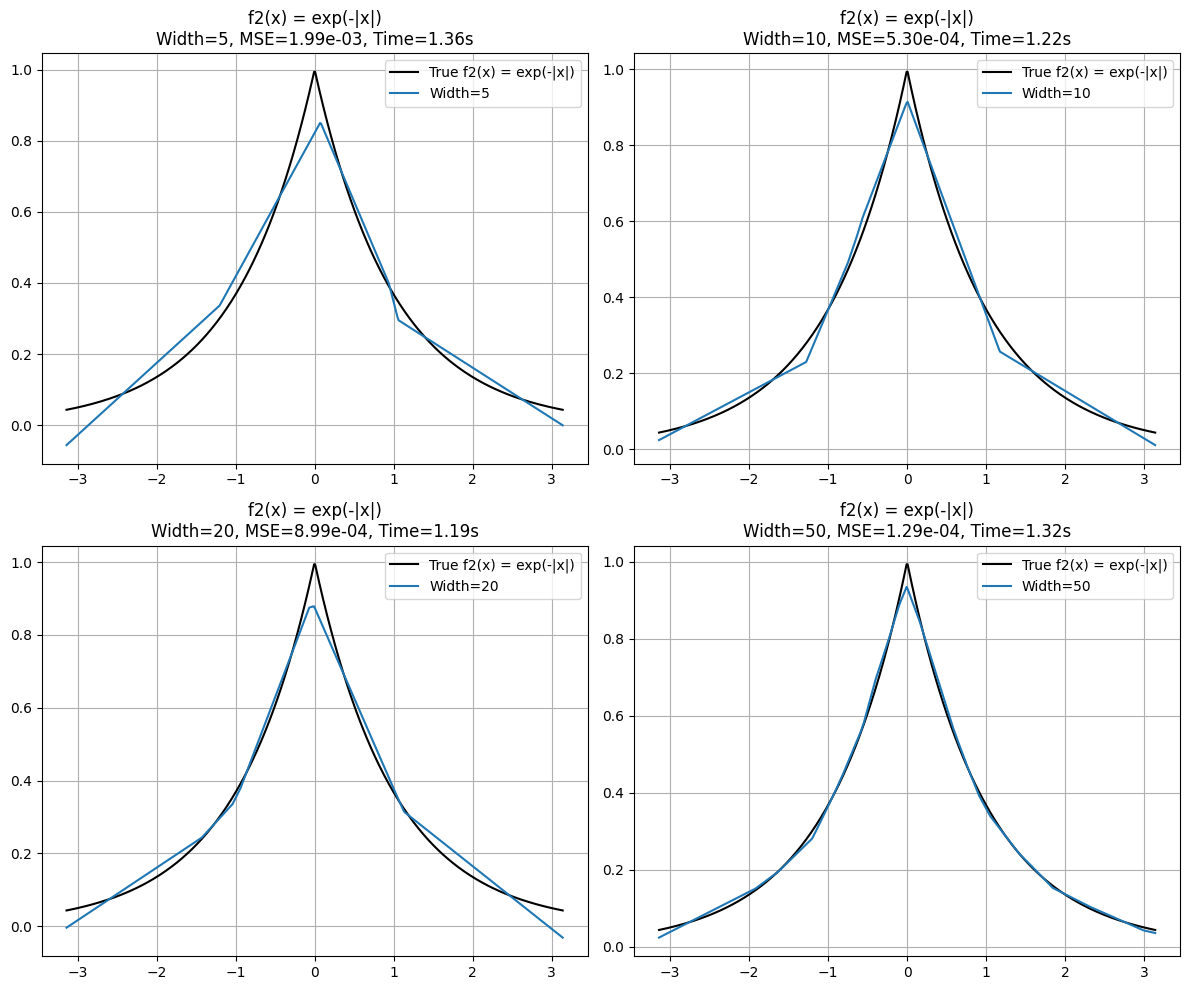

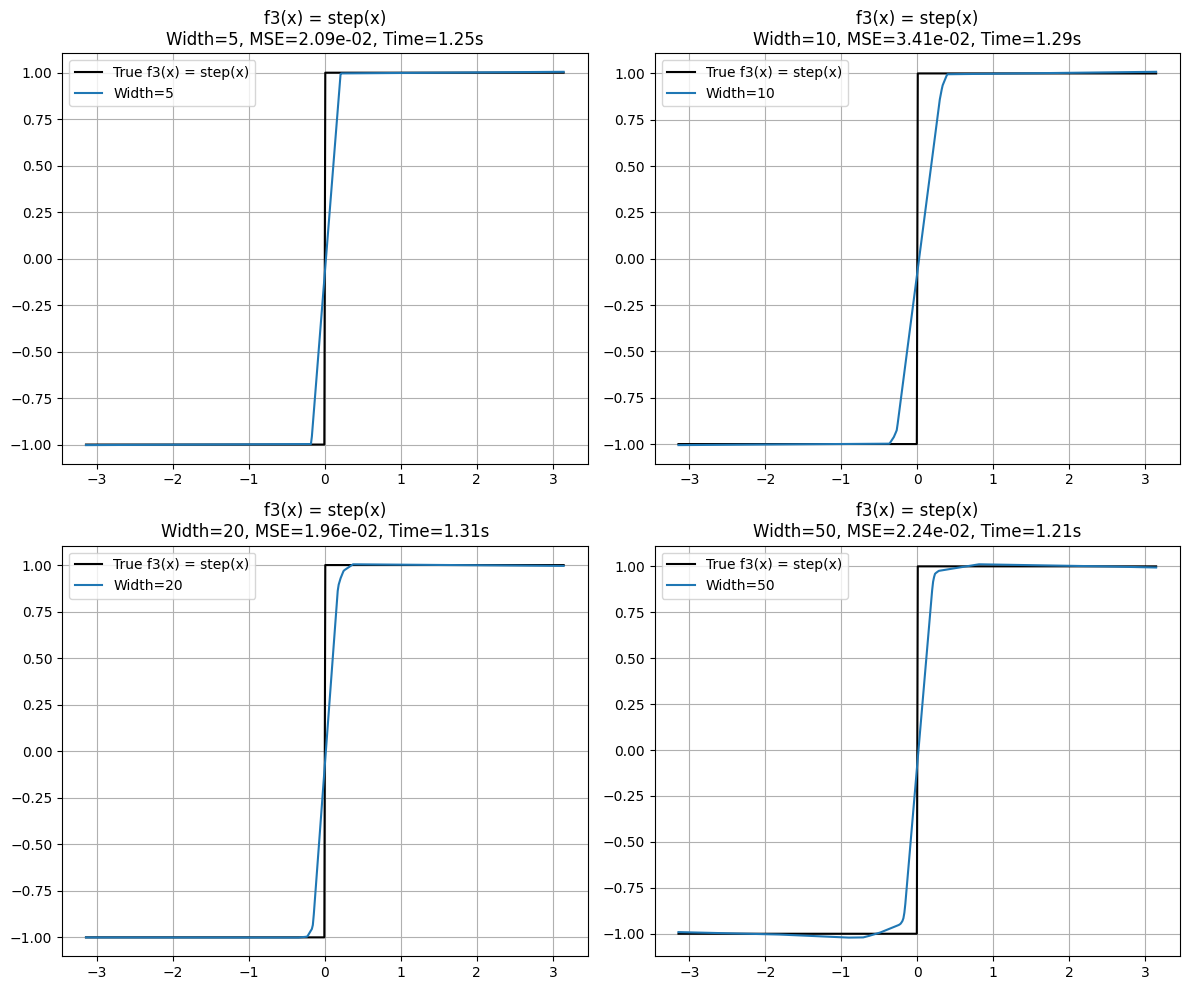

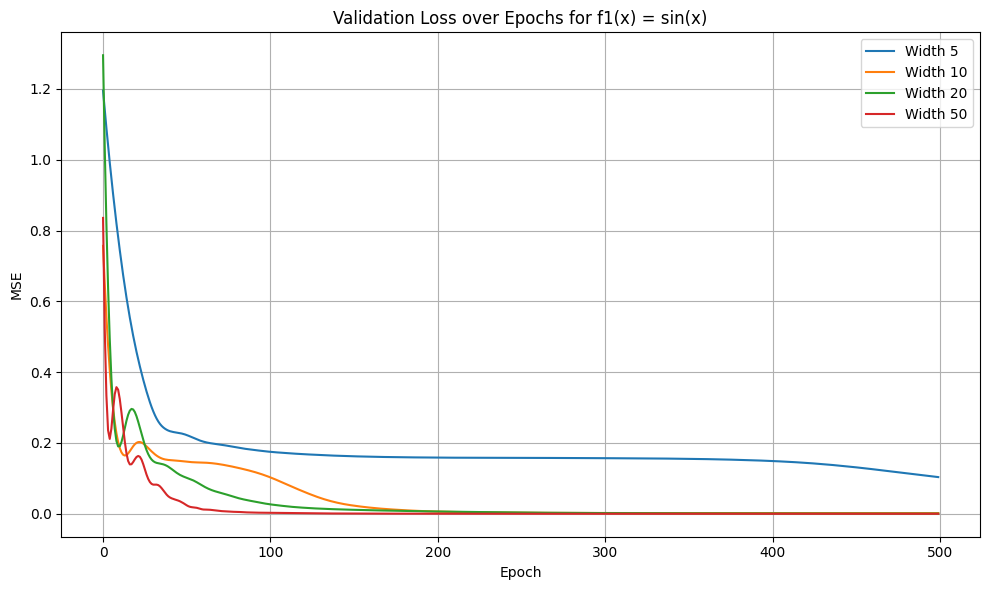

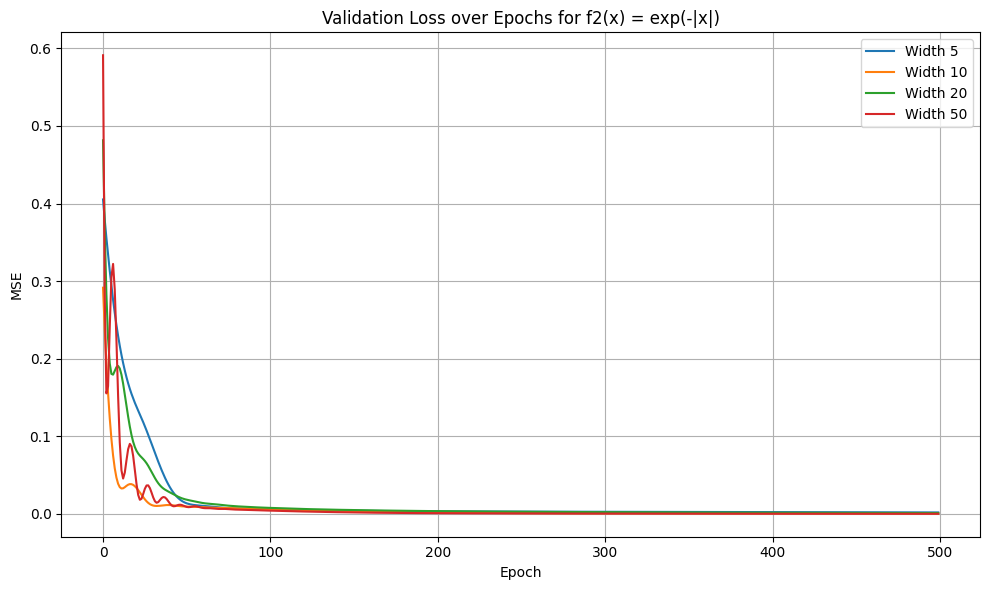

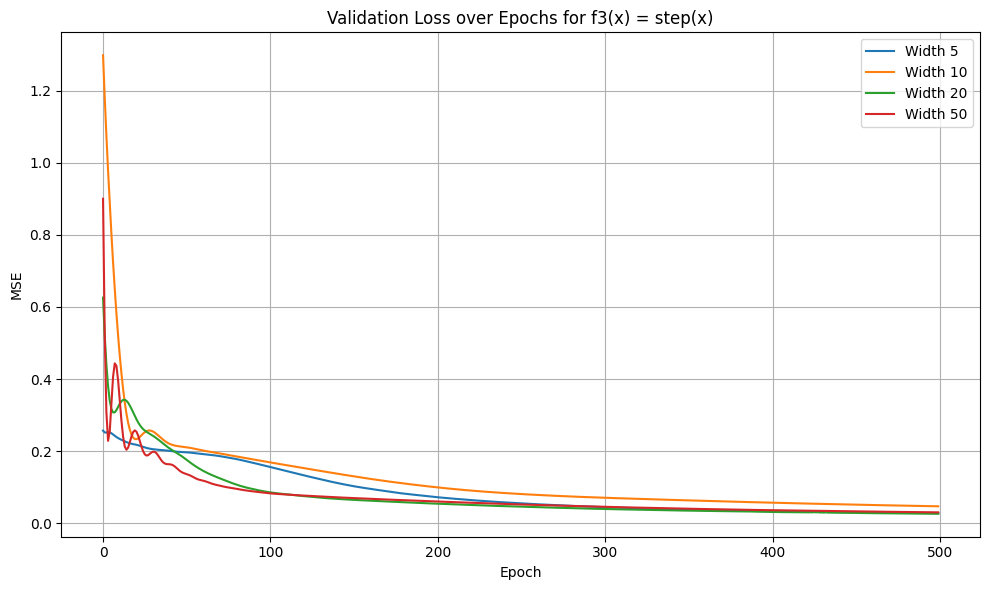

In [54]:
"""
C3: Shallow Neural Networks
"""

# Define shallow network
class ShallowNet(nn.Module):
    def __init__(self, hidden_units):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, 1)
        )

    def forward(self, x):
        return self.net(x)

# Train model with tqdm
def train_model(model, x_train, y_train, x_val, y_val, epochs=500, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []

    for epoch in trange(epochs, desc="Training", leave=False):
        model.train()
        optimizer.zero_grad()
        pred = model(x_train).squeeze()
        loss = criterion(pred, y_train.squeeze())
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(x_val).squeeze()
            val_loss = criterion(val_pred, y_val.squeeze())

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

    return train_losses, val_losses

# Configurations
hidden_sizes = [5, 10, 20, 50]
target_keys = ['f1', 'f2', 'f3']
target_names = ['f1(x) = sin(x)', 'f2(x) = exp(-|x|)', 'f3(x) = step(x)']
targets = [f1, f2, f3]
train_tensors = [f1_train_tensor, f2_train_tensor, f3_train_tensor]
val_tensors = [f1_val_tensor, f2_val_tensor, f3_val_tensor]

# Run experiments
shallow_results = {}

for key, name, full_target, y_train, y_val in zip(target_keys, target_names, targets, train_tensors, val_tensors):
    shallow_results[key] = {}
    print(f"\n--- Results for {name} ---")
    for h in hidden_sizes:
        model = ShallowNet(h).to(device)

        start_time = time.time()
        train_losses, val_losses = train_model(model, x_train_tensor, y_train, x_val_tensor, y_val)
        train_time = time.time() - start_time

        with torch.no_grad():
            y_pred = model(torch.tensor(x, dtype=torch.float32).to(device)).cpu().squeeze().numpy()
            mse = mean_squared_error(full_target, y_pred)

        print(f"Width {h:2d} → Val MSE: {mse:.4e}, Time: {train_time:.2f}s")

        shallow_results[key][h] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'mse': mse,
            'y_pred': y_pred,
            'train_time': train_time
        }

# ---- Plot predicted vs true ----
for i, key in enumerate(target_keys):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for j, h in enumerate(hidden_sizes):
        ax = axes[j // 2, j % 2]
        ax.plot(x, targets[i], label='True ' + target_names[i], color='black')
        ax.plot(x, shallow_results[key][h]["y_pred"], label=f'Width={h}')
        mse = shallow_results[key][h]["mse"]
        t = shallow_results[key][h]["train_time"]
        ax.set_title(f'{target_names[i]}\nWidth={h}, MSE={mse:.2e}, Time={t:.2f}s')
        ax.legend()
        ax.grid(True)
    plt.tight_layout()
    plt.show()

# ---- Plot validation losses ----
for i, key in enumerate(target_keys):
    plt.figure(figsize=(10, 6))
    for h in hidden_sizes:
        plt.plot(shallow_results[key][h]['val_losses'], label=f'Width {h}')
    plt.title(f'Validation Loss over Epochs for {target_names[i]}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



--- Results for f1(x) = sin(x) ---


Depth  5, Width  3 → Val MSE: 1.4351e-01, Time: 5.55s


Depth 10, Width  2 → Val MSE: 2.4334e-01, Time: 10.24s


Depth 20, Width  1 → Val MSE: 4.9698e-01, Time: 20.08s

--- Results for f2(x) = exp(-|x|) ---


Depth  5, Width  3 → Val MSE: 2.8780e-02, Time: 6.29s


Depth 10, Width  2 → Val MSE: 5.9651e-02, Time: 11.02s


Depth 20, Width  1 → Val MSE: 6.6115e-02, Time: 21.06s

--- Results for f3(x) = step(x) ---


Depth  5, Width  3 → Val MSE: 8.0260e-02, Time: 5.97s


Depth 10, Width  2 → Val MSE: 1.0024e+00, Time: 10.88s


Depth 20, Width  1 → Val MSE: 1.0135e+00, Time: 19.36s


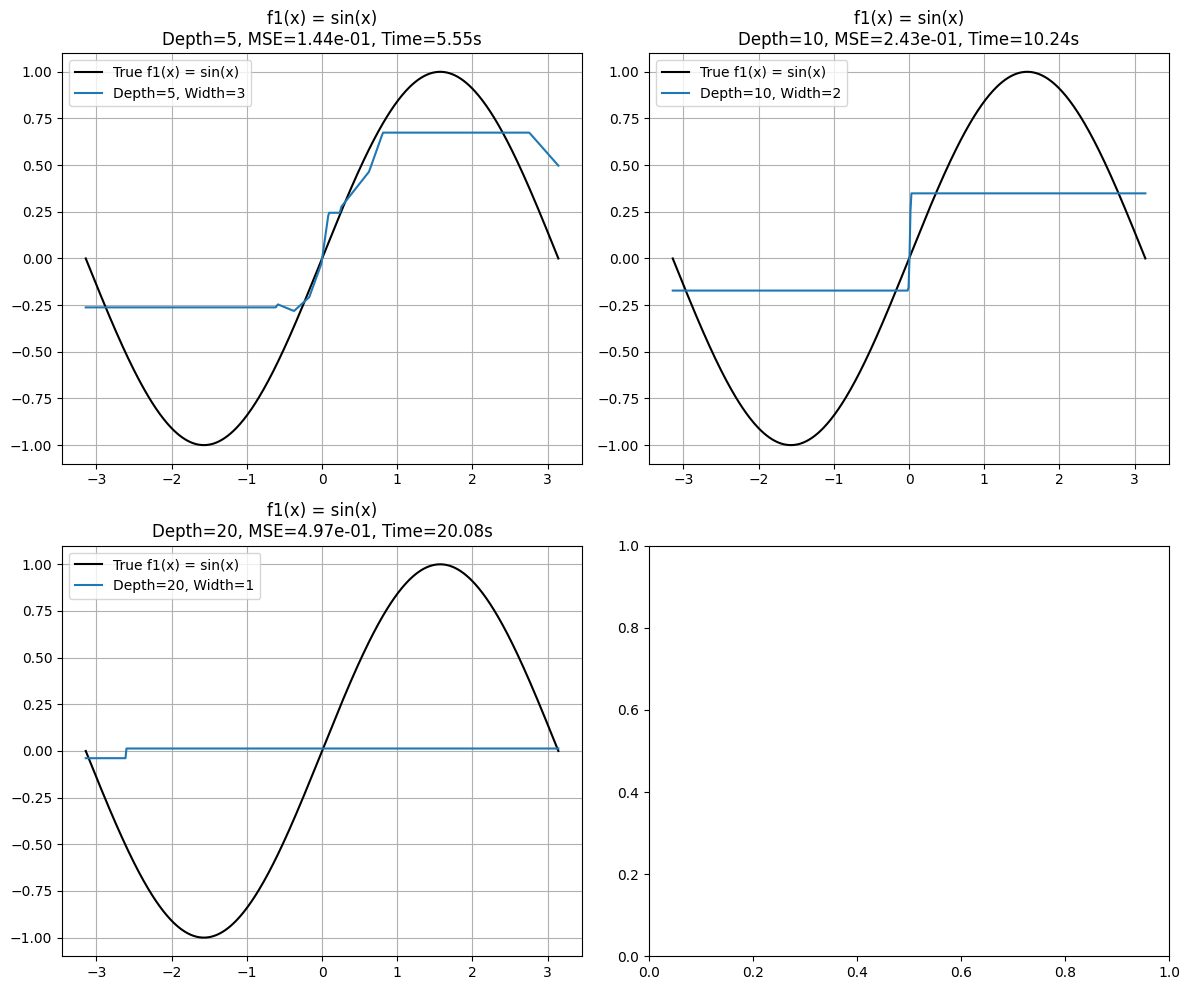

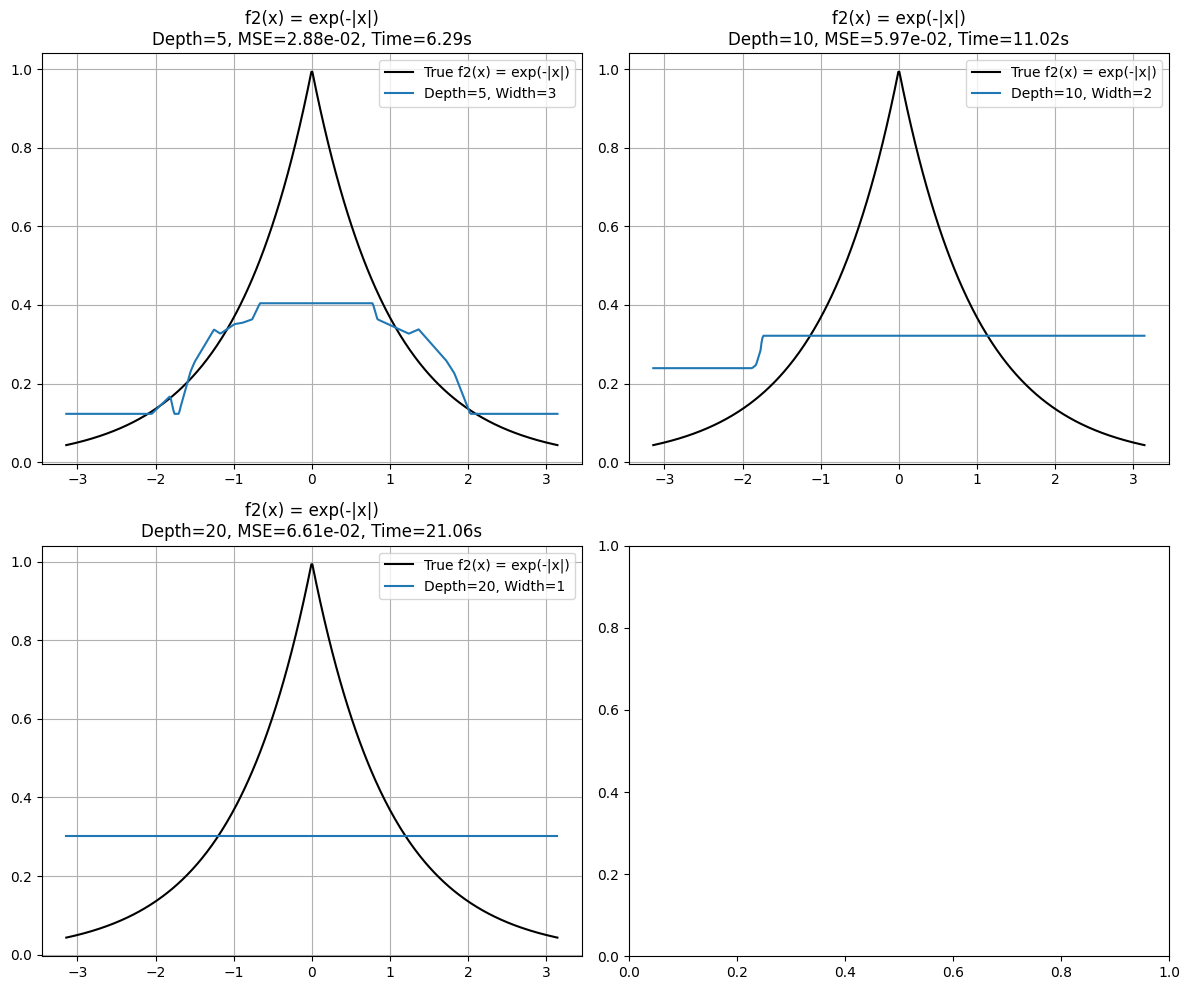

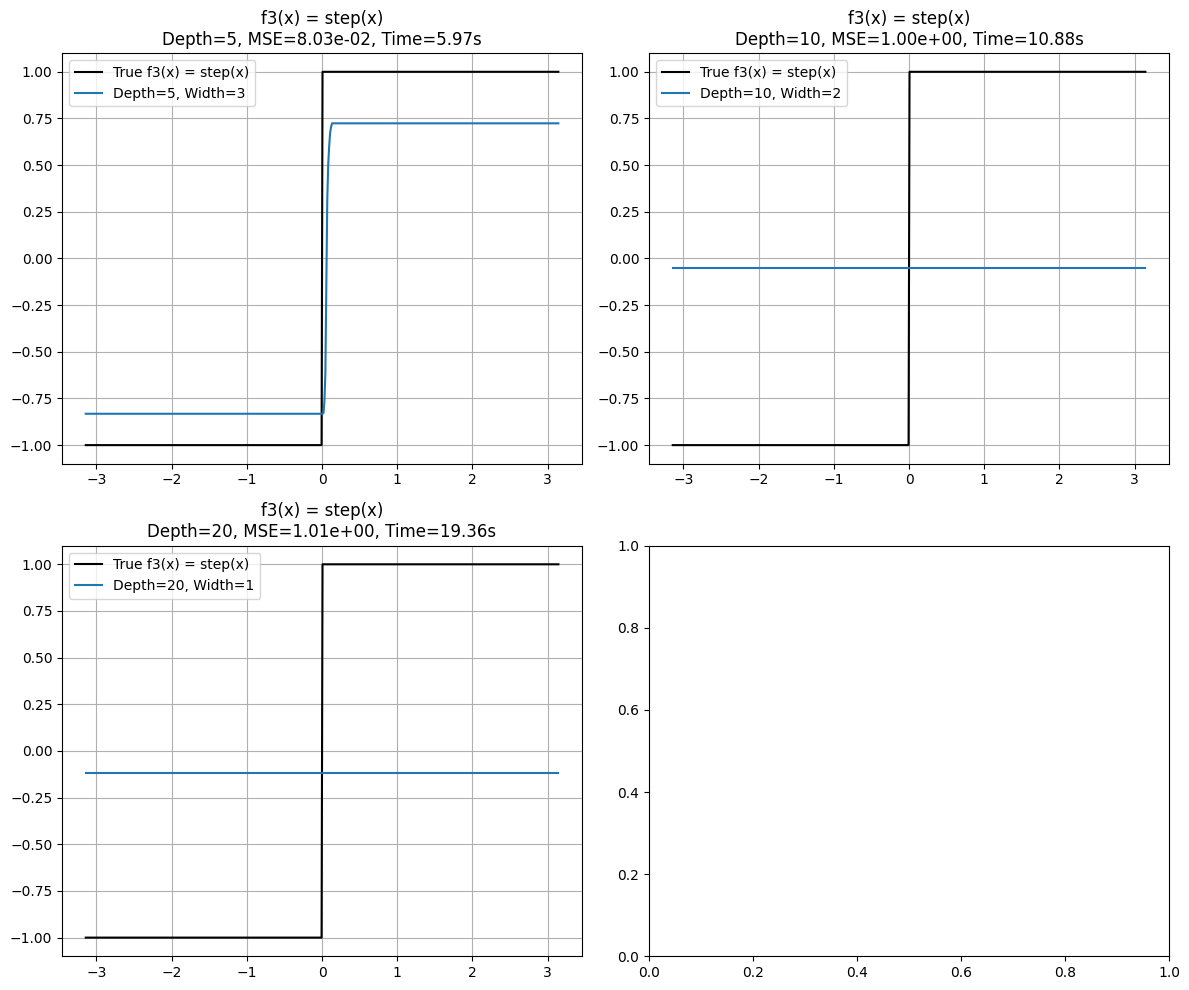

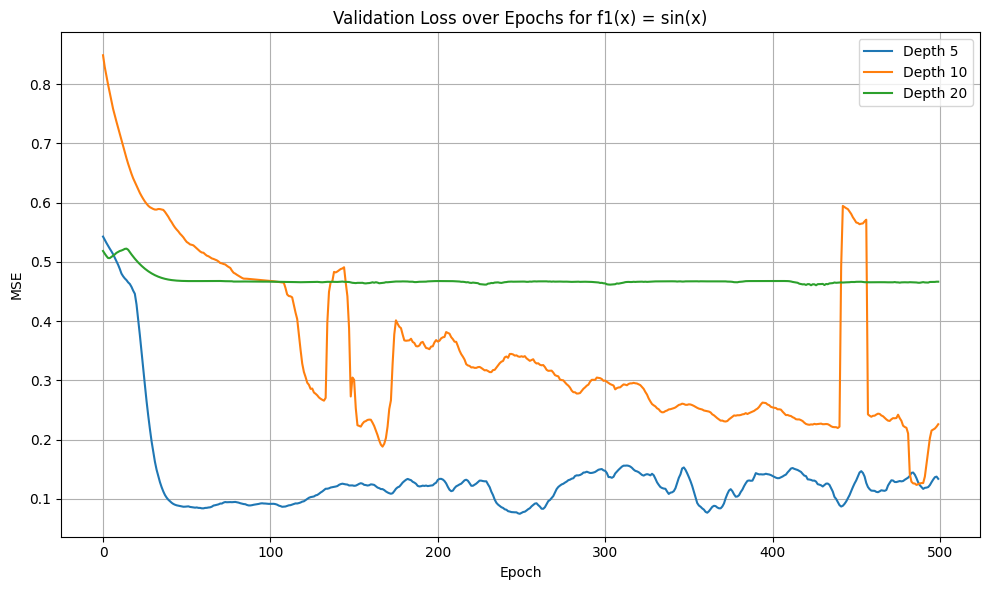

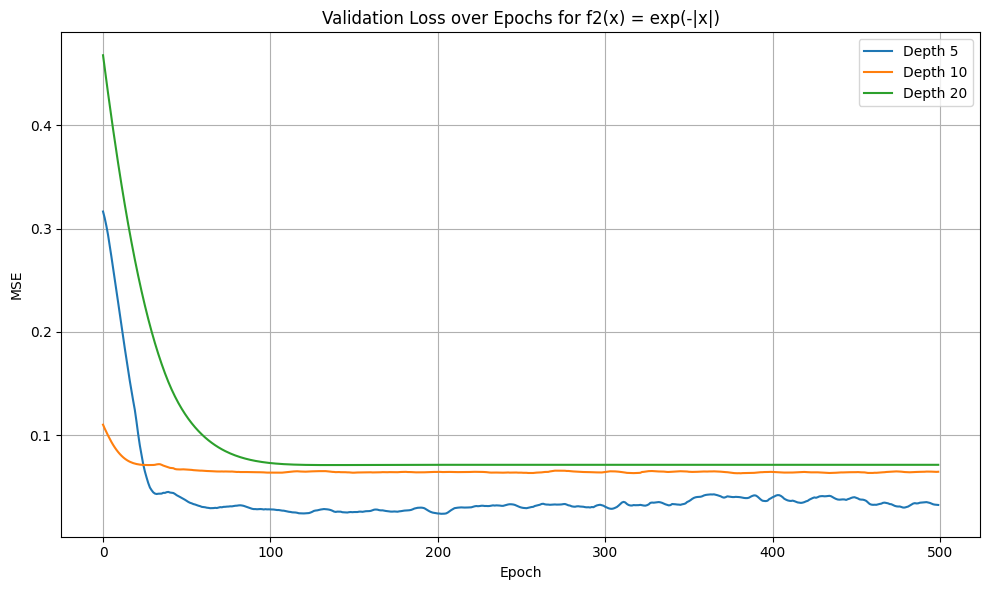

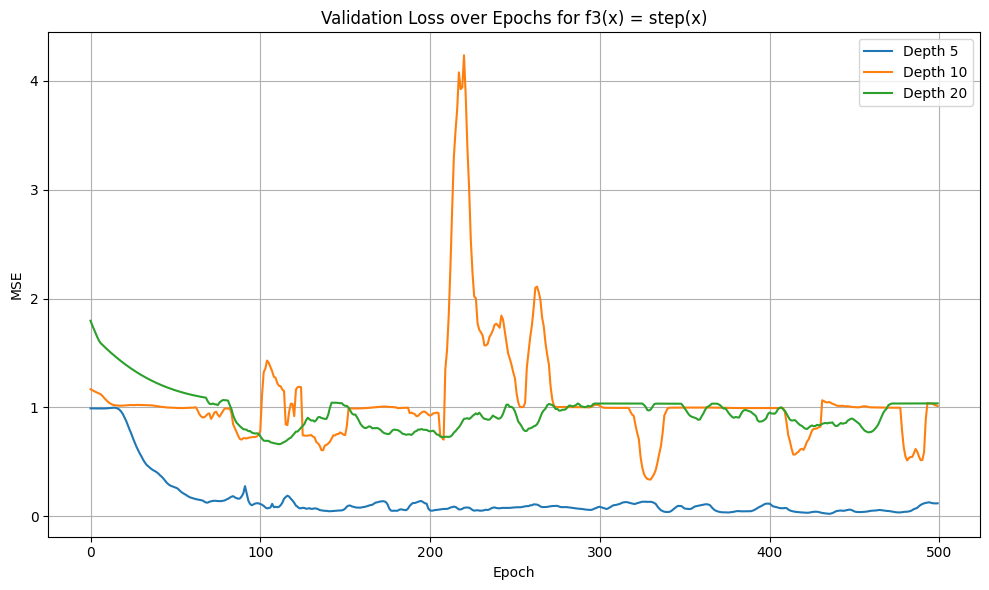

In [55]:
"""
C4: Deep Neural Networks
"""

# Define deep network
class DeepNet(nn.Module):
    def __init__(self, depth, width, use_bn=False, dropout_rate=0.0):
        super().__init__()
        layers = []
        for i in range(depth):
            input_dim = width if i > 0 else 1
            layers.append(nn.Linear(input_dim, width))
            if use_bn:
                layers.append(nn.BatchNorm1d(width))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(width, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Train model with tqdm
def train_model(model, x_train, y_train, x_val, y_val, epochs=500, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []

    for epoch in trange(epochs, desc="Training", leave=False):
        model.train()
        optimizer.zero_grad()
        pred = model(x_train).squeeze()
        loss = criterion(pred, y_train.squeeze())
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(x_val).squeeze()
            val_loss = criterion(val_pred, y_val.squeeze())

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

    return train_losses, val_losses

# Match parameter count to shallow net
shallow_params = sum(p.numel() for p in nn.Sequential(nn.Linear(1, 20), nn.ReLU(), nn.Linear(20, 1)).parameters())
def estimate_width(depth):
    return int(np.sqrt(shallow_params / depth))

# Configurations
depths = [5, 10, 20]
target_keys = ['f1', 'f2', 'f3']
target_names = ['f1(x) = sin(x)', 'f2(x) = exp(-|x|)', 'f3(x) = step(x)']
targets = [f1, f2, f3]
train_tensors = [f1_train_tensor, f2_train_tensor, f3_train_tensor]
val_tensors = [f1_val_tensor, f2_val_tensor, f3_val_tensor]

# Run experiments
deep_results = {}

for key, name, full_target, y_train, y_val in zip(target_keys, target_names, targets, train_tensors, val_tensors):
    deep_results[key] = {}
    print(f"\n--- Results for {name} ---")
    for depth in depths:
        width = estimate_width(depth)
        model = DeepNet(depth=depth, width=width, use_bn=True, dropout_rate=0.1).to(device)

        start_time = time.time()
        train_losses, val_losses = train_model(model, x_train_tensor, y_train, x_val_tensor, y_val)
        train_time = time.time() - start_time

        with torch.no_grad():
            y_pred = model(torch.tensor(x, dtype=torch.float32).to(device)).cpu().squeeze().numpy()
            mse = mean_squared_error(full_target, y_pred)

        print(f"Depth {depth:2d}, Width {width:2d} → Val MSE: {mse:.4e}, Time: {train_time:.2f}s")

        deep_results[key][depth] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'mse': mse,
            'y_pred': y_pred,
            'train_time': train_time,
            'width': width
        }

# ---- Plot predictions ----
for i, key in enumerate(target_keys):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for j, depth in enumerate(depths):
        ax = axes[j // 2, j % 2]
        ax.plot(x, targets[i], label='True ' + target_names[i], color='black')
        ax.plot(x, deep_results[key][depth]["y_pred"], label=f'Depth={depth}, Width={deep_results[key][depth]["width"]}')
        mse = deep_results[key][depth]["mse"]
        t = deep_results[key][depth]["train_time"]
        ax.set_title(f'{target_names[i]}\nDepth={depth}, MSE={mse:.2e}, Time={t:.2f}s')
        ax.legend()
        ax.grid(True)
    plt.tight_layout()
    plt.show()

# ---- Plot validation loss ----
for i, key in enumerate(target_keys):
    plt.figure(figsize=(10, 6))
    for depth in depths:
        plt.plot(deep_results[key][depth]['val_losses'], label=f'Depth {depth}')
    plt.title(f'Validation Loss over Epochs for {target_names[i]}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


- **Initialization and Regularization Strategies**:  
  To stabilize training and improve generalization in our deep neural networks, we employed two key regularization techniques: **batch normalization** and **dropout**. Batch normalization was added after each hidden layer to mitigate internal covariate shift and allow for more stable and faster convergence. Dropout was applied with a rate of 0.1 to randomly deactivate a fraction of the hidden units during training, which reduces overfitting and encourages the network to learn redundant, robust representations. These strategies were especially important given the depth of our models, as deeper networks are more prone to optimization difficulties such as vanishing gradients. Despite their use, the deep networks still struggled to match the performance of shallow models due to their limited width and capacity.


### C.5: Comparative Analysis

In this section, we compared the approximation performance and training efficiency of shallow and deep feedforward neural networks across three target functions:

- `f₁(x) = sin(x)` — smooth and periodic  
- `f₂(x) = exp(-|x|)` — smooth with a sharp peak  
- `f₃(x)` — a discontinuous step function

Shallow networks with a single hidden layer and varying width consistently outperformed their deeper counterparts in terms of validation mean squared error (MSE), particularly for the smooth functions `f₁` and `f₂`. For example, a shallow network with 50 hidden units achieved MSE values several orders of magnitude lower than deep networks with 5, 10, or 20 layers, where the width was constrained to match the total parameter count of the shallow networks.

In terms of training time, shallow networks completed in roughly **1.3–1.5 seconds**, while deep networks took between **6 and 22 seconds** depending on the depth. This gap reflects both the increased number of operations in deep models and their slower convergence behavior. Although deep networks are theoretically more expressive, this benefit was not realized in our setup due to their very limited width (as low as 2–4 units per layer), which restricted capacity and led to underfitting.

For the discontinuous function `f₃`, both architectures struggled, as expected, due to the sharp jump at `x = 0`. However, shallow networks still produced better approximations than deep networks, both in terms of MSE and qualitative behavior.

Overall, these results demonstrate that **depth alone is not sufficient** for good approximation performance — especially when width and training dynamics are constrained. For low-dimensional, smooth functions, **wide shallow networks are often more effective**, easier to optimize, and computationally more efficient than their deep counterparts.


### C.6: Discussion and Reflection

This experiment highlighted the trade-offs between depth, expressiveness, and optimization in neural network architectures. While deep networks are theoretically capable of approximating a wide range of complex functions, our results show that **depth alone is not sufficient** to guarantee strong performance. In practice, depth must be balanced with **sufficient width**, appropriate initialization, and effective regularization strategies to be successful.

Shallow networks, particularly those with a single wide hidden layer, consistently outperformed their deep counterparts across all three target functions. They were able to approximate both smooth and non-smooth functions with lower validation error and significantly faster training times. This is likely because shallow networks with enough parameters are easier to optimize and can directly model the function without needing hierarchical feature compositions.

Deep networks, on the other hand, suffered from limited capacity due to constrained width, leading to underfitting even with regularization techniques like batch normalization and dropout. They also required longer training times and showed slower convergence.

Depth can be beneficial in scenarios where the target function exhibits **compositional or hierarchical structure**, or when working with **high-dimensional input spaces** where local reuse of features is important. However, in low-dimensional settings with smooth functions, **shallow and wide architectures are often more practical and effective**.

All three of these functions are quite simple and non-compositional in nature, which is why the benefits of a deep network are not applicable, and it's more effective to just directly approximate the functions -- as in a shallow NN. 

Overall, these findings reinforce that architectural choices must be guided by the nature of the problem, computational constraints, and training dynamics — and that deeper is not always better.

## Probem 3: Optimization

### Problem 3A (1a): Visualizing the Loss Landscape and Network Output

We consider a small neural network with one hidden layer and two ReLU neurons:

$$
f_\theta(x) = \alpha_1 \cdot \text{ReLU}(w_1 x + b_1) + \alpha_2 \cdot \text{ReLU}(w_2 x + b_2)
$$

The goal of this task is to explore how each of the six parameters — $w_1, w_2, b_1, b_2, \alpha_1, \alpha_2$ — affects the shape of the function $f_\theta(x)$ by plotting the network output as each parameter is varied independently, while the others are held fixed.

This helps us build intuition about how individual parameters influence the piecewise linear structure of the network’s output.


## Problem 3A(1a): Parameter Sensitivity Visualization

- For each parameter, we generate three plots:
  1. The baseline case where **all parameters are set to 1**.
  2. A variation where that specific parameter is increased to 2.
  3. A variation where that specific parameter is decreased to -2.
- All **other parameters are held fixed at 1** in every plot.

This isolates and reveals the influence of each individual parameter on the network output.


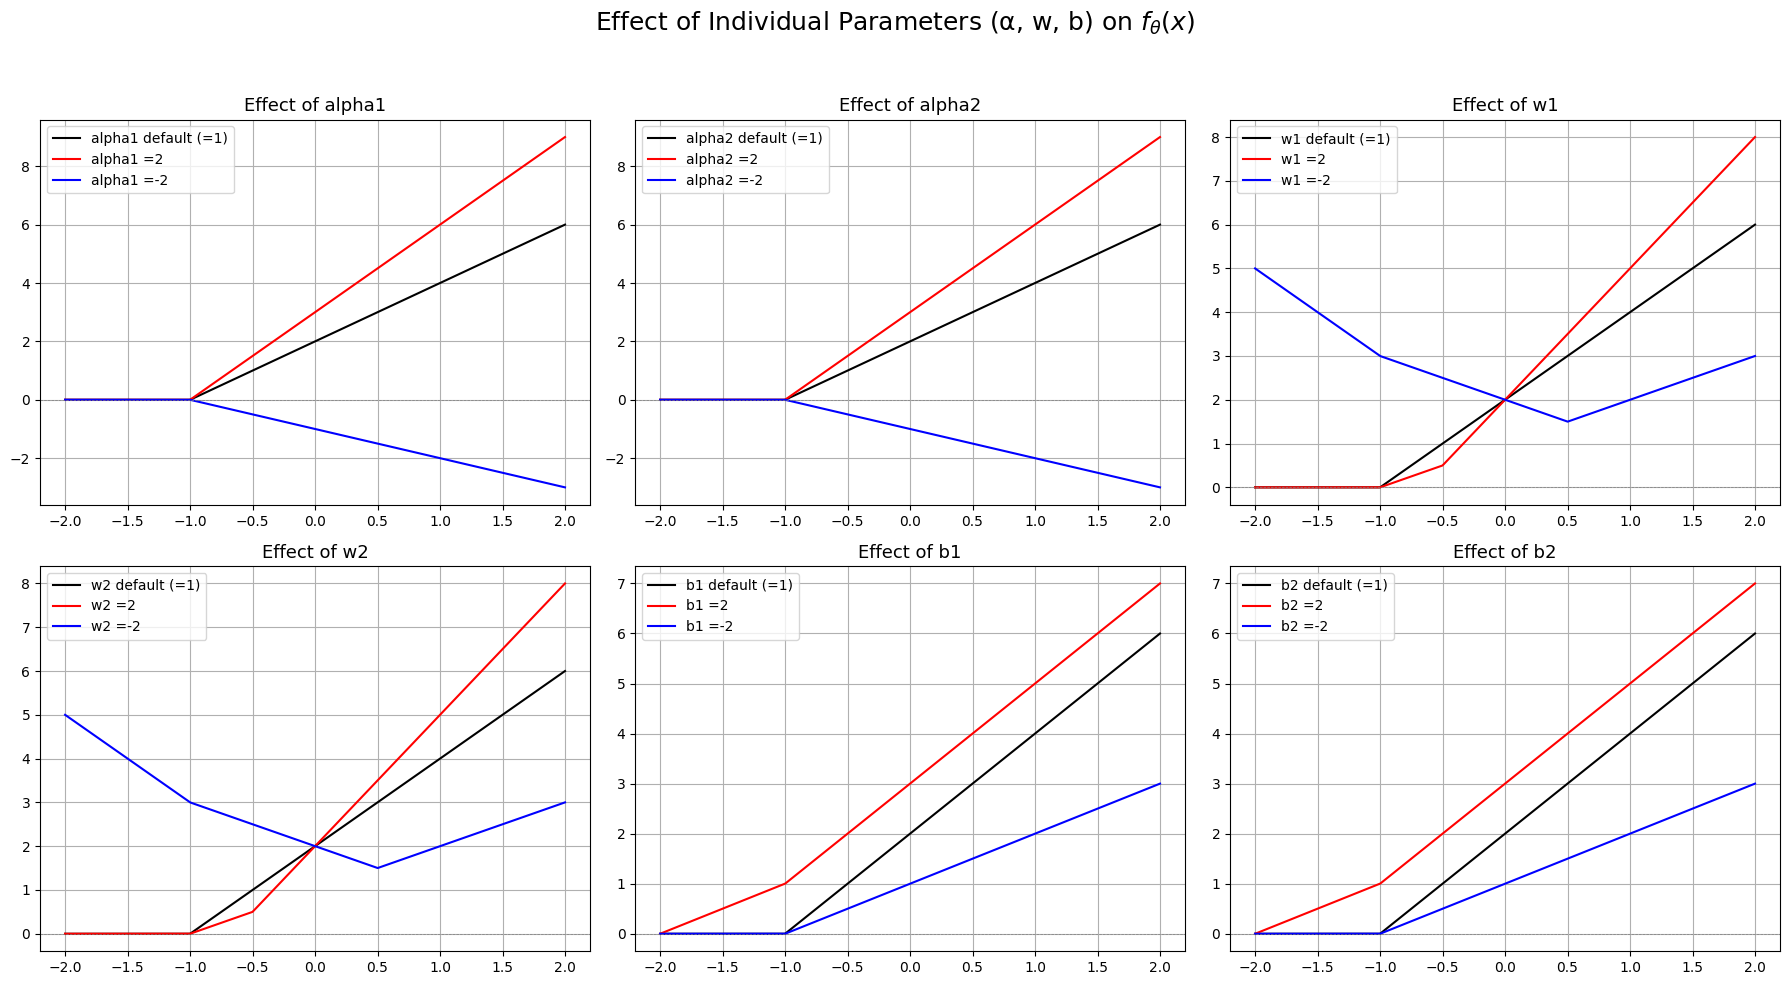

In [60]:
# ReLU function
def relu(x):
    return np.maximum(0, x)

# Network definition
def f_theta(x, alpha1, alpha2, w1, w2, b1, b2):
    return alpha1 * relu(w1 * x + b1) + alpha2 * relu(w2 * x + b2)

# Input range
x = np.linspace(-2, 2, 500)

# Default baseline (all ones)
baseline = {
    "alpha1": 1,
    "alpha2": 1,
    "w1": 1,
    "w2": 1,
    "b1": 1,
    "b2": 1,
}

# Parameters to explore
param_names = ["alpha1", "alpha2", "w1", "w2", "b1", "b2"]

# Variations: baseline, +2, -2 for each
variations = [1.0, 2.0, -2.0]
labels = ["default (=1)", "=2", "=-2"]
colors = ["black", "red", "blue"]

# Create plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, param in enumerate(param_names):
    ax = axes[idx]
    for val, label, color in zip(variations, labels, colors):
        p = baseline.copy()
        p[param] = val
        y = f_theta(x, **p)
        ax.plot(x, y, label=f"{param} {label}", color=color)
    
    ax.set_title(f"Effect of {param}", fontsize=13)
    ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')
    ax.grid(True)
    ax.legend()

plt.suptitle("Effect of Individual Parameters (α, w, b) on $f_\\theta(x)$", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Problem 3A(1a): Qualitative Effects of Individual Parameters on Output

#### alpha1 and alpha2 (output weights):
- Control the strength and sign of each neuron's output.
- Positive values stretch the output upward; negative values flip it vertically.
- Setting alpha1 or alpha2 to 0 removes the corresponding neuron's contribution.

#### w1 and w2 (input weights):
- Control the slope of each ReLU segment after activation.
- Larger magnitudes produce steeper slopes.
- Changing the sign flips the slope direction and changes which side of the threshold gets activated.

#### b1 and b2 (biases):
- Control the horizontal shift of each neuron's ReLU activation threshold.
- Increasing the bias moves the activation point left (activates earlier).
- Decreasing the bias delays activation and can suppress it entirely on some input regions.

These parameters interact to determine the shape, position, and amplitude of the piecewise-linear output function.


### Problem 3A(1b): Compute Gradients Using PyTorch Autograd

We define a simple feedforward network with one hidden layer consisting of two ReLU units:

    f_theta(x) = alpha1 * ReLU(w1 * x + b1) + alpha2 * ReLU(w2 * x + b2)

The training set consists of three points:

    x = [-1, 0, 1]
    y_i = sin(x_i)

We initialize all parameters to 1 and define the loss as the **sum of squared errors**:

    L(theta) = Σ_i (f_theta(x_i) - y_i)^2

Using PyTorch’s autograd engine, we compute the gradient of the loss with respect to each parameter (note that general formulas for the gradient terms have been derived by hand as well -- see pdf).


In [71]:
# Training data
x = torch.tensor([[-1], [0], [1]])         # shape (3, 1)
y = torch.sin(x)                     # shape (3,)

# Parameters initialized to 1.0, with gradient tracking
alpha1 = torch.tensor(1.0, requires_grad=True)
alpha2 = torch.tensor(1.0, requires_grad=True)
w1     = torch.tensor(1.0, requires_grad=True)
w2     = torch.tensor(1.0, requires_grad=True)
b1     = torch.tensor(1.0, requires_grad=True)
b2     = torch.tensor(1.0, requires_grad=True)

# Define the model
def f_theta(x):
    h1 = F.relu(w1 * x + b1)
    h2 = F.relu(w2 * x + b2)
    return alpha1 * h1 + alpha2 * h2

# Compute predictions
preds = f_theta(x)

# Compute loss: sum of squared errors
loss = torch.sum((preds - y) ** 2)

# Backward pass
loss.backward()

# Print gradient values
print(f"Loss: {loss.item():.4f}")
print("Gradient values:")
print(f"∂L/∂alpha1 = {alpha1.grad.item():.4f}")
print(f"∂L/∂alpha2 = {alpha2.grad.item():.4f}")
print(f"∂L/∂w1     = {w1.grad.item():.4f}")
print(f"∂L/∂w2     = {w2.grad.item():.4f}")
print(f"∂L/∂b1     = {b1.grad.item():.4f}")
print(f"∂L/∂b2     = {b2.grad.item():.4f}")


Loss: 14.6844
Gradient values:
∂L/∂alpha1 = 16.6341
∂L/∂alpha2 = 16.6341
∂L/∂w1     = 6.3171
∂L/∂w2     = 6.3171
∂L/∂b1     = 10.3171
∂L/∂b2     = 10.3171


### Problem 3A(c) – Finding and Classifying a Critical Point
After locating a critical point numerically (via GD) we classify it by computing the **Hessian matrix** of second derivatives and analyzing its **eigenvalues**:

- If all eigenvalues are positive → local minimum  
- If some eigenvalues are negative → saddle point  
- If zero eigenvalues dominate → flat or degenerate region

We also compute the **condition number** of the Hessian to understand the curvature and potential optimization difficulties near the critical point.

In [82]:
# Learning rate
lr = 0.01
params = [alpha1, alpha2, w1, w2, b1, b2]

# Gradient descent loop
for epoch in range(3000):
    # Zero gradients
    for p in params:
        p.grad.zero_()


    # Forward pass
    h1 = F.relu(w1 * x + b1)
    h2 = F.relu(w2 * x + b2)
    preds = alpha1 * h1 + alpha2 * h2
    preds = preds.squeeze()

    # Compute loss
    loss = torch.sum((preds - y) ** 2)

    # Note: loss.backward() computes gradients for all parameters
    loss.backward()

    # Manual parameter update
    with torch.no_grad():
        for p in params:
            p -= lr * p.grad

    # Print progress
    if epoch % 500 == 0:
        grad_norm = sum(p.grad.detach().norm().item() for p in params)
        print(f"Epoch {epoch:4d} | Loss = {loss.item():.6f} | Grad Norm = {grad_norm:.6f}")

# Final report
print("\n--- Final Results ---")
print(f"Loss: {loss.item():.6f}")
for name, p in zip(['alpha1', 'alpha2', 'w1', 'w2', 'b1', 'b2'], params):
    print(f"{name} = {p.item():.6f}")
print(f"Gradient Norm = {sum(p.grad.detach().norm().item() for p in params):.6f}")


Epoch    0 | Loss = 0.708073 | Grad Norm = 0.000004
Epoch  500 | Loss = 0.708073 | Grad Norm = 0.000004
Epoch 1000 | Loss = 0.708073 | Grad Norm = 0.000004
Epoch 1500 | Loss = 0.708073 | Grad Norm = 0.000004
Epoch 2000 | Loss = 0.708073 | Grad Norm = 0.000004
Epoch 2500 | Loss = 0.708073 | Grad Norm = 0.000004

--- Final Results ---
Loss: 0.708073
alpha1 = 0.396504
alpha2 = 0.396504
w1 = 1.061111
w2 = 1.061111
b1 = 0.000001
b2 = 0.000001
Gradient Norm = 0.000004


In [79]:
# Final trained parameters from part (b) -- 
theta_vals = [0.396504, 0.396504, 1.061112, 1.061112, 0.000001, 0.000001]
flat_params = [torch.tensor(v, dtype=torch.float64, requires_grad=True) for v in theta_vals]

# Training data
x = torch.tensor([[-1.0], [0.0], [1.0]], dtype=torch.float64)
y = torch.sin(x).squeeze()

# Define loss
def compute_loss(params):
    a1, a2, w1, w2, b1, b2 = params
    h1 = F.relu(w1 * x + b1)
    h2 = F.relu(w2 * x + b2)
    preds = a1 * h1 + a2 * h2
    return torch.sum((preds.squeeze() - y) ** 2)

# Compute gradient vector
loss = compute_loss(flat_params)
grads = grad(loss, flat_params, create_graph=True)

# Compute Hessian matrix (memory-safe)
n = len(flat_params)
hessian = torch.zeros((n, n), dtype=torch.float64)

for i in range(n):
    second_grads = grad(grads[i], flat_params, retain_graph=True)
    hessian[i] = torch.tensor([g.item() for g in second_grads], dtype=torch.float64)

# Convert to NumPy and analyze
hessian_np = hessian.detach().numpy()
eigenvalues = np.linalg.eigvalsh(hessian_np)
cond_number = np.max(np.abs(eigenvalues)) / np.maximum(np.min(np.abs(eigenvalues)), 1e-12)

# Print results
print("\n--- HESSIAN ---")
print(hessian_np)
print("\nEigenvalues:", eigenvalues)
print(f"\nCondition number: {cond_number:.4e}")



--- HESSIAN ---
[[2.2519216  2.2519216  0.84147132 0.8414711  0.8414737  0.84147189]
 [2.2519216  2.2519216  0.8414711  0.84147132 0.84147189 0.8414737 ]
 [0.84147132 0.8414711  0.31443084 0.31443084 0.31443084 0.31443084]
 [0.8414711  0.84147132 0.31443084 0.31443084 0.31443084 0.31443084]
 [0.8414737  0.84147189 0.31443084 0.31443084 0.62886169 0.62886169]
 [0.84147189 0.8414737  0.31443084 0.31443084 0.62886169 0.62886169]]

Eigenvalues: [-1.82626983e-06 -1.48332524e-07 -5.49101516e-19  1.82626983e-06
  5.52934203e-01  5.83749420e+00]

Condition number: 5.8375e+12


### 3A(c) – Critical Point Classification Reflection

We found a critical point numerically by applying gradient descent to the full loss over the 3-point training set. The gradient norm at the final iterate was ≈ 0.000004, confirming it is a critical point.

We computed the full Hessian matrix at this point and analyzed its eigenvalues. The eigenvalue spectrum includes both negative and positive values, as well as one nearly zero eigenvalue:

    [-1.83e-06, -1.48e-07, -5.49e-19, 1.83e-06, 0.553, 5.837]

This confirms that the critical point is a **saddle point**, not a local minimum, since there are directions of both positive and negative curvature.

Furthermore, the **condition number** of the Hessian is approximately:

    κ ≈ 5.84 × 10¹²

This extremely high condition number indicates the optimization landscape is **ill-conditioned** near the critical point, meaning gradient descent would exhibit slow and potentially unstable convergence in certain directions.



### Problem 3B – Gradient Descent and Learning Rates

In this part, we investigate how the learning rate affects optimization behavior. Using the same ReLU network setup from Problem 3A, we implement manual gradient descent with different fixed learning rates:

- η = 0.01
- η = 0.1
- η = 1.0

For each learning rate, we track:
- The evolution of the loss over training iterations
- The trajectory of selected parameters (α₁ and w₁) in 2D space

These experiments will help us assess how step size influences convergence speed and stability.


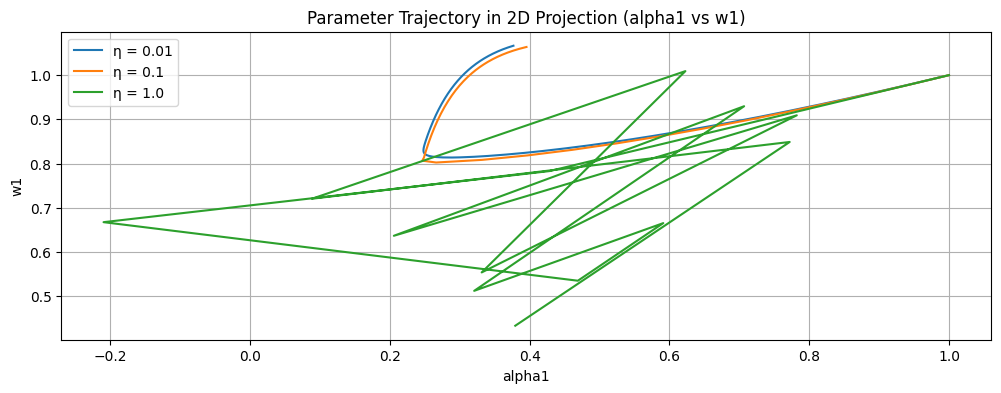

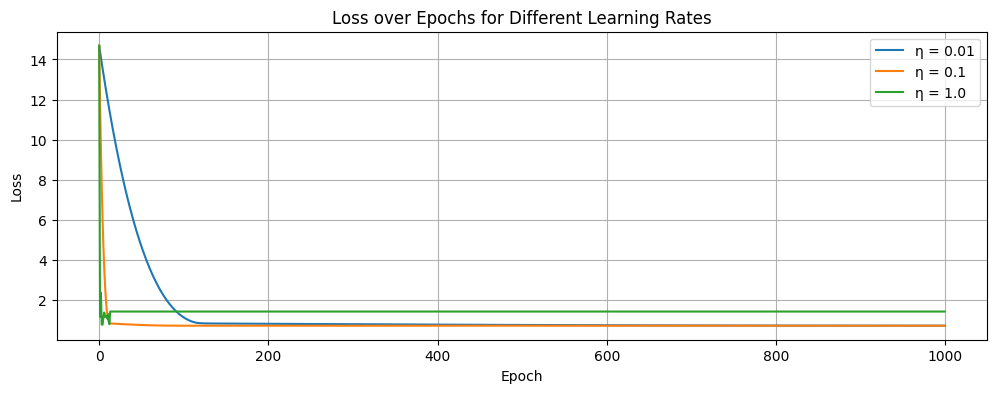

In [84]:
# Learning rates to try
learning_rates = [0.01, 0.1, 1.0]
num_epochs = 1000
projections = (0, 2)  # alpha1 (index 0), w1 (index 2)

# Store results for plotting
trajectories = {}
loss_curves = {}

for lr in learning_rates:
    # Initialize parameters (same starting point for consistency)
    alpha1 = torch.tensor(1.0, requires_grad=True)
    alpha2 = torch.tensor(1.0, requires_grad=True)
    w1     = torch.tensor(1.0, requires_grad=True)
    w2     = torch.tensor(1.0, requires_grad=True)
    b1     = torch.tensor(1.0, requires_grad=True)
    b2     = torch.tensor(1.0, requires_grad=True)
    params = [alpha1, alpha2, w1, w2, b1, b2]

    traj = []
    losses = []

    for epoch in range(num_epochs):
        # Zero gradients
        for p in params:
            if p.grad is not None:
                p.grad.zero_()

        # Forward pass
        h1 = F.relu(w1 * x + b1)
        h2 = F.relu(w2 * x + b2)
        preds = alpha1 * h1 + alpha2 * h2
        preds = preds.squeeze()

        # Compute loss
        loss = torch.sum((preds - y) ** 2)
        losses.append(loss.item())

        # Backward pass
        loss.backward()

        # Gradient clipping to stabilize training
        torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)

        # Record projection of parameters
        proj_coords = [params[projections[0]].item(), params[projections[1]].item()] # alpha1, w1
        traj.append(proj_coords)

        # Manual update
        with torch.no_grad():
            for p in params:
                p -= lr * p.grad

    trajectories[lr] = traj
    loss_curves[lr] = losses

# Plot parameter trajectories
plt.figure(figsize=(12, 4))
for lr, traj in trajectories.items():
    traj = torch.tensor(traj)
    plt.plot(traj[:, 0], traj[:, 1], label=f'η = {lr}')
plt.xlabel('alpha1')
plt.ylabel('w1')
plt.title('Parameter Trajectory in 2D Projection (alpha1 vs w1)')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss curves
plt.figure(figsize=(12, 4))
for lr, losses in loss_curves.items():
    plt.plot(losses, label=f'η = {lr}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()


### Problem 3B(3) – Interpretation

#### Loss Curves
- **η = 0.01**: Converges smoothly, though relatively slowly. Loss plateaus at a slightly higher value due to smaller updates.
- **η = 0.1**: Converges faster than η = 0.01 and achieves a lower final loss. This learning rate offers the best trade-off between stability and speed in this setting.
- **η = 1.0**: Exhibits unstable behavior early in training (large oscillations in the loss curve) and settles to a suboptimal plateau. Although the final loss stabilizes, it remains significantly higher than that for η = 0.1 --- this indicates overshooting.

#### Parameter Trajectories (α₁ vs. w₁)
- **η = 0.01 and 0.1** follow a smooth path toward a local minimum. The higher η = 0.1 moves faster and covers more ground early on.
- **η = 1.0** traces a jagged and erratic trajectory, reflecting unstable parameter updates due to large step sizes. Despite gradient clipping, the optimizer oscillates and struggles to converge directly.

#### Interpretation
- **Small learning rates** (like 0.01) offer stability but converge slowly.
- **Moderate learning rates** (like 0.1) are more efficient, achieving lower loss in fewer steps without sacrificing stability.
- **Large learning rates** (like 1.0) can destabilize training, especially in non-convex or piecewise-linear models like ReLU networks, leading to poor convergence or divergence.

Choosing an appropriate learning rate is essential for balancing convergence speed and stability. In this case, **η = 0.1** provides the most effective optimization path.


## 3C: Conditioning and Curvature: 
Note that we already found the Hessian and condition number of the Hessian in 3A-C:
Eigenvalues:
[-1.82626983e-06 -1.48332524e-07 -5.49101516e-19  1.82626983e-06
  5.52934203e-01  5.83749420e+00]

Condition number: 5.8375e+12. The Hessian has very small eigenvalues, suggesting near-flat directions (poor curvature), while the condition number is extremely large, which implies ill-conditioning — gradient descent will be slow and unstable in certain directions. 

We will approach the last part of the problem below: Modify the loss function with weight decay and assess how this affects the conditioning of the Hessian?


In [85]:
# Final trained parameters from earlier (local minimum)
theta_vals = [0.396504, 0.396504, 1.061112, 1.061112, 0.000001, 0.000001]
flat_params = [torch.tensor(v, dtype=torch.float64, requires_grad=True) for v in theta_vals]

# Training data
x = torch.tensor([[-1.0], [0.0], [1.0]], dtype=torch.float64)
y = torch.sin(x).squeeze()

# Regularization strength
lambda_reg = 0.1

# Modified loss function with weight decay
def compute_regularized_loss(params):
    a1, a2, w1, w2, b1, b2 = params

    # Compute model predictions
    h1 = F.relu(w1 * x + b1)
    h2 = F.relu(w2 * x + b2)
    preds = a1 * h1 + a2 * h2
    preds = preds.squeeze()

    # MSE loss
    mse_loss = torch.sum((preds - y) ** 2)

    # L2 regularization term: lambda * ||theta||^2
    l2_term = lambda_reg * sum(p.pow(2).sum() for p in params)

    return mse_loss + l2_term

# Compute first-order gradients
loss = compute_regularized_loss(flat_params)
grads = grad(loss, flat_params, create_graph=True)

# Compute Hessian matrix
n = len(flat_params)
hessian = torch.zeros((n, n), dtype=torch.float64)

for i in range(n):
    second_grads = grad(grads[i], flat_params, retain_graph=True)
    hessian[i] = torch.tensor([g.item() for g in second_grads], dtype=torch.float64)

# Convert to NumPy and analyze
hessian_np = hessian.detach().numpy()
eigenvalues = np.linalg.eigvalsh(hessian_np)
condition_number = np.max(np.abs(eigenvalues)) / np.maximum(np.min(np.abs(eigenvalues)), 1e-12)

# Print results
print("\n--- Hessian with L2 Regularization ---")
print(hessian_np)
print("\nEigenvalues:", eigenvalues)
print(f"\nCondition number: {condition_number:.4e}")



--- Hessian with L2 Regularization ---
[[2.4519216  2.2519216  0.84147132 0.8414711  0.8414737  0.84147189]
 [2.2519216  2.4519216  0.8414711  0.84147132 0.84147189 0.8414737 ]
 [0.84147132 0.8414711  0.51443084 0.31443084 0.31443084 0.31443084]
 [0.8414711  0.84147132 0.31443084 0.51443084 0.31443084 0.31443084]
 [0.8414737  0.84147189 0.31443084 0.31443084 0.82886169 0.62886169]
 [0.84147189 0.8414737  0.31443084 0.31443084 0.62886169 0.82886169]]

Eigenvalues: [0.19999817 0.19999985 0.2        0.20000183 0.7529342  6.0374942 ]

Condition number: 3.0188e+01


### Problem C(3) – Effect of L2 Regularization on Conditioning

We introduced an L2 regularization term into the loss function:

Using λ = 0.1 and recomputing the Hessian at the same local minimum, we obtained the following results:

- **Eigenvalues**: [0.19999817, 0.19999985, 0.2, 0.20000183, 0.7529342, 6.0374942]

- **Condition number**: approx 30.19


#### Interpretation:

- **Improved Conditioning**:  
  Compared to the unregularized case (condition number ≈ 5.8e+12), the regularized Hessian is significantly better conditioned. The smallest eigenvalues are now bounded away from zero due to the added diagonal curvature from the regularization term.

- **Stabilized Curvature**:  
  The regularization acts as a form of **ridge stabilization**, making the loss landscape more curved in previously flat directions. This helps avoid ill-conditioned regions that slow down gradient descent or cause it to become unstable.

- **Numerical Impact**:  
  The condition number of ~30 is relatively low, indicating that gradient descent will behave more predictably. Convergence is less sensitive to step size, and the updates are more isotropic (less skewed across parameter directions).

#### Conclusion:

Adding L2 regularization improves the curvature of the loss function and results in a much more numerically stable optimization landscape. This is especially important in overparameterized or poorly scaled models where flat directions are common.


## Problem 3D: Stochastic gradient descent (SGD) and noise:
This section compares Stochastic Gradient Descent (SGD) and full-batch gradient descent (GD) using a small neural network and dataset.

**Dataset:**
- We generate 10 input values `x_i` uniformly sampled from [-1, 1].
- The target values are `y_i = sin(x_i)`.

**Network:**
- Same ReLU-based neural network from previous problems.

**Tasks:**
1. Implement full-batch gradient descent on the network.
2. Implement SGD with batch size = 1 (i.e., one data point per update).
3. Track and compare:
   - Training loss across iterations.
   - 2D trajectories of selected parameters (e.g., alpha1 vs w1).

**Goal:** Understand how gradient noise affects convergence and stability in a simple model, even with a small dataset.



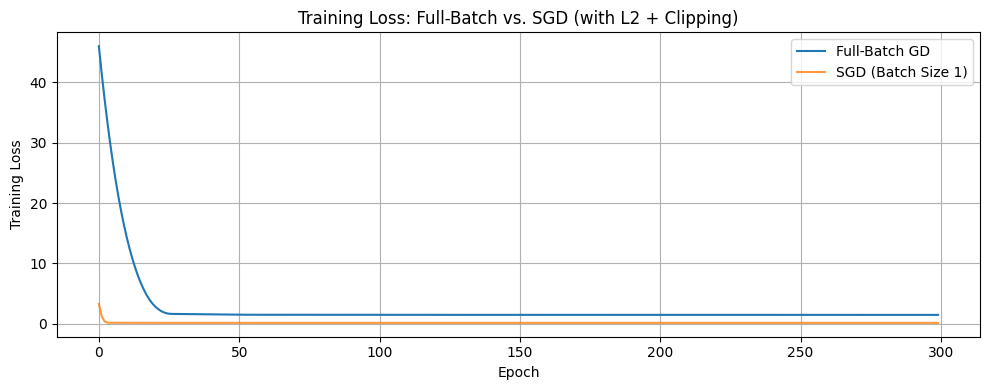

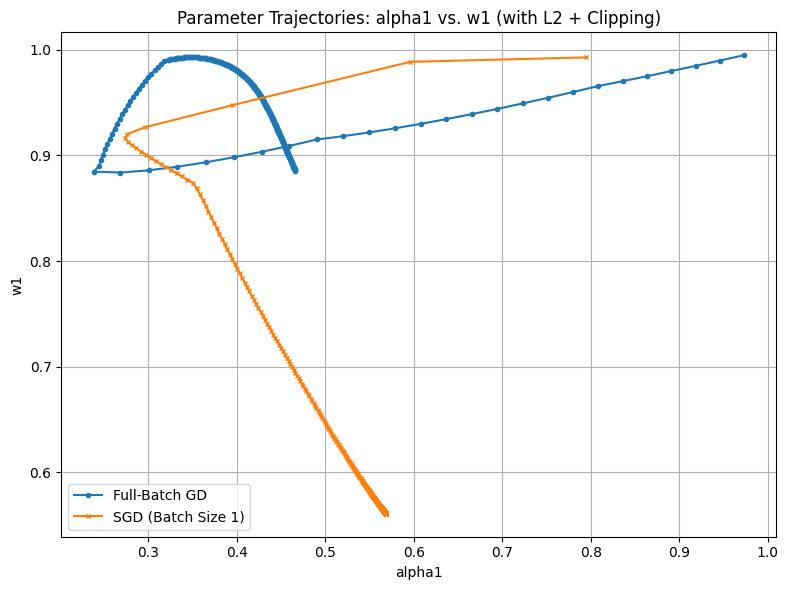

In [114]:
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Generate 10 training points in [-1, 1]
x = np.random.uniform(-1, 1, size=(10, 1))
y = np.sin(x)

# Convert to torch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).squeeze()

# Hyperparameters
num_epochs = 300
lr = 0.05
lambda_reg = 0.01   # L2 regularization coefficient
clip_value = 1.0    # Max norm for gradient clipping

# Containers to store history
loss_history_full = []
loss_history_sgd = []
traj_full = []
traj_sgd = []

# -------- FULL-BATCH GD --------
# Initialize parameters
alpha1 = torch.tensor(1.0, requires_grad=True)
alpha2 = torch.tensor(1.0, requires_grad=True)
w1     = torch.tensor(1.0, requires_grad=True)
w2     = torch.tensor(1.0, requires_grad=True)
b1     = torch.tensor(1.0, requires_grad=True)
b2     = torch.tensor(1.0, requires_grad=True)
params_full = [alpha1, alpha2, w1, w2, b1, b2]

for epoch in range(num_epochs):
    for p in params_full:
        if p.grad is not None:
            p.grad.zero_()

    h1 = F.relu(w1 * x_tensor + b1)
    h2 = F.relu(w2 * x_tensor + b2)
    preds = alpha1 * h1 + alpha2 * h2
    mse_loss = torch.sum((preds.squeeze() - y_tensor) ** 2)
    reg = lambda_reg * sum(p.pow(2).sum() for p in params_full)
    loss = mse_loss + reg

    loss.backward()
    torch.nn.utils.clip_grad_norm_(params_full, max_norm=clip_value)

    with torch.no_grad():
        for p in params_full:
            p -= lr * p.grad

    loss_history_full.append(loss.item())
    traj_full.append([alpha1.item(), w1.item()])


# -------- SGD (batch size 1) --------
# Re-initialize
alpha1 = torch.tensor(1.0, requires_grad=True)
alpha2 = torch.tensor(1.0, requires_grad=True)
w1     = torch.tensor(1.0, requires_grad=True)
w2     = torch.tensor(1.0, requires_grad=True)
b1     = torch.tensor(1.0, requires_grad=True)
b2     = torch.tensor(1.0, requires_grad=True)
params_sgd = [alpha1, alpha2, w1, w2, b1, b2]

for epoch in range(num_epochs):
    total_loss = 0.0
    for i in range(len(x_tensor)):
        xi = x_tensor[i:i+1]
        yi = y_tensor[i]

        for p in params_sgd:
            if p.grad is not None:
                p.grad.zero_()

        h1 = F.relu(w1 * xi + b1)
        h2 = F.relu(w2 * xi + b2)
        pred = alpha1 * h1 + alpha2 * h2
        mse = (pred.squeeze() - yi) ** 2
        reg = lambda_reg * sum(p.pow(2).sum() for p in params_sgd)
        loss = mse + reg

        loss.backward()
        torch.nn.utils.clip_grad_norm_(params_sgd, max_norm=clip_value)

        with torch.no_grad():
            for p in params_sgd:
                p -= lr * p.grad

        total_loss += loss.item()

    loss_history_sgd.append(total_loss / len(x_tensor))
    traj_sgd.append([alpha1.item(), w1.item()])


# -------- PLOTTING --------
traj_full_np = np.array(traj_full)
traj_sgd_np = np.array(traj_sgd)

# Plot Loss curves
plt.figure(figsize=(10, 4))
plt.plot(loss_history_full, label='Full-Batch GD')
plt.plot(loss_history_sgd, label='SGD (Batch Size 1)', alpha=0.8)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss: Full-Batch vs. SGD (with L2 + Clipping)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot parameter trajectory
plt.figure(figsize=(8, 6))
plt.plot(traj_full_np[:, 0], traj_full_np[:, 1], label="Full-Batch GD", marker='o', markersize=3)
plt.plot(traj_sgd_np[:, 0], traj_sgd_np[:, 1], label="SGD (Batch Size 1)", marker='x', markersize=3)
plt.xlabel("alpha1")
plt.ylabel("w1")
plt.title("Parameter Trajectories: alpha1 vs. w1 (with L2 + Clipping)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Problem D(4): Discussion on SGD vs. Full-Batch GD
Stability: Full-batch gradient descent exhibits smoother updates and follows a predictable trajectory. However, it can get stuck in flatter regions or take longer to escape shallow curvature areas. SGD, while noisier, introduces stochastic fluctuations that can help it navigate out of such regions.

Speed of Convergence: SGD converges faster to a lower training loss, despite its noisy path. This is particularly noticeable early in training due to its more frequent updates (once per data point).

Parameter Trajectories: Full-batch GD follows a more stable and curved path in the parameter space. In contrast, SGD's trajectory is more erratic but appears to explore the space more thoroughly.

Advantages of SGD:

Enables faster convergence due to frequent updates.

Adds beneficial noise that can help escape saddle points or sharp minima.

Requires less computation per step, making it more scalable to large datasets.

Even on small datasets, it can act as an implicit regularizer by not overfitting to all samples equally in each step.